In [1]:
import sys
from pathlib import Path
from tqdm import tqdm

import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from skimage.measure import compare_ssim
from skimage.measure import compare_psnr

import chainer
import chainer.functions as F
sns.set(style='darkgrid')

sys.path.append('../experiments/SSVG/')
from net import Encoder, Decoder, Discriminator
%matplotlib inline

In [2]:
FILE_PATH = Path('.').resolve()
ROOT_PATH = FILE_PATH.parent
RESULT_PATH = ROOT_PATH.joinpath('results/SSVG')
MODEL_PATH = ROOT_PATH.joinpath('models/SSVG')
print(FILE_PATH)
print(ROOT_PATH)
print(RESULT_PATH)
print(MODEL_PATH)

/home/shimo/CMULAB/Spatio-Temporal-SR/Notebooks
/home/shimo/CMULAB/Spatio-Temporal-SR
/home/shimo/CMULAB/Spatio-Temporal-SR/results/SSVG
/home/shimo/CMULAB/Spatio-Temporal-SR/models/SSVG


In [3]:
FILE_PATH = Path('.').resolve()
ROOT_PATH = FILE_PATH.parent
RESULT_PATH = ROOT_PATH.joinpath('results/SSVG')
MODEL_PATH = ROOT_PATH.joinpath('models/SSVG')
print(FILE_PATH)
print(ROOT_PATH)
print(RESULT_PATH)
print(MODEL_PATH)

/home/shimo/CMULAB/Spatio-Temporal-SR/Notebooks
/home/shimo/CMULAB/Spatio-Temporal-SR
/home/shimo/CMULAB/Spatio-Temporal-SR/results/SSVG
/home/shimo/CMULAB/Spatio-Temporal-SR/models/SSVG


In [4]:
test_data = np.load(ROOT_PATH.joinpath('datasets/moving_mnist_test.npy')) \
              .reshape(-1, 20, 1, 64, 64).astype(np.float32) / 255.0
train_data = np.load(ROOT_PATH.joinpath('datasets/moving_mnist_train.npy')) \
               .reshape(-1, 20, 1, 64, 64).astype(np.float32) / 255.0
print(test_data.shape, test_data.dtype, train_data.max())
print(train_data.shape, train_data.dtype, train_data.max())

(1000, 20, 1, 64, 64) float32 1.0
(9000, 20, 1, 64, 64) float32 1.0


In [5]:
encoder = Encoder(64, 1, 100, 4)
decoder = Decoder(64, 1, 100, 4)


chainer.serializers.load_npz(MODEL_PATH.joinpath('mmnist',
    'Encoder_SSVG_201901311621_epoch200_latent100_ch4_coef11.0_coef20.5_coef31.0_coef40.1.npz'), encoder)
chainer.serializers.load_npz(MODEL_PATH.joinpath('mmnist',
    'Decoder_SSVG_201901311621_epoch200_latent100_ch4_coef11.0_coef20.5_coef31.0_coef40.1.npz'), decoder)

In [6]:
x = test_data[:9, 0]
print(x.shape)

with chainer.using_config('train', False), chainer.no_backprop_mode():
        x_rec = F.sigmoid(decoder(encoder(x)[0])).array \
                .reshape(-1, 64, 64)
print(x_rec.shape, x_rec.max(), x_rec.min(), x_rec.dtype)
x_rec = np.clip(np.array(x_rec)*255, 0, 255).astype(np.uint8)

(9, 1, 64, 64)
(9, 64, 64) 0.98558176 0.0 float32


(9, 64, 64) 251 uint8


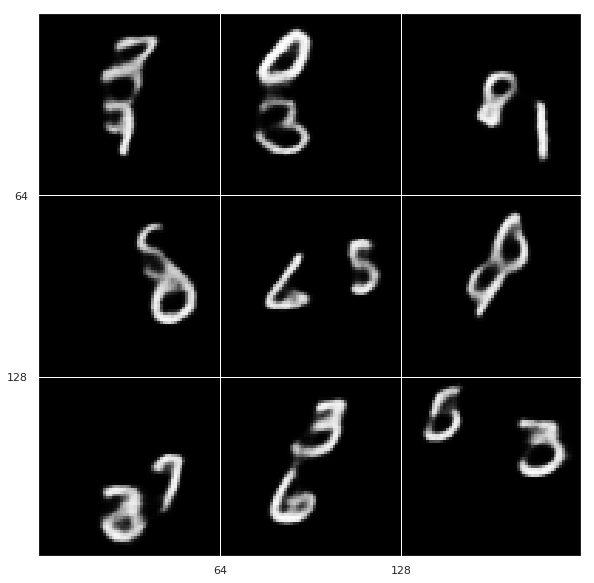

In [7]:
print(x_rec.shape, x_rec.max(), x_rec.dtype)

plt.figure(figsize=(10, 10))
plt.grid(True)
plt.xticks(np.arange(64, 64 * 3, 64))
plt.yticks(np.arange(64, 64 * 3, 64))
plt.imshow(x_rec.reshape(3,3,64,64).transpose(0,2,1,3).reshape(64*3, 64*3), cmap='gray')
plt.imsave('./images/SSVG/mmnist_ssvg_noframe.png', x_rec.reshape(3,3,64,64).transpose(0,2,1,3).reshape(64*3, 64*3), cmap='gray')
plt.savefig('./images/SSVG/mmnist_ssvg.png')
plt.show()

In [8]:
# test
psnrs = []
ssims = []

for x_true in tqdm(test_data[:,0]):
    x_true = x_true[np.newaxis, :]
    x_rec = F.sigmoid(decoder(encoder(x_true)[0])).array
    x_true = np.clip(x_true*255, 0, 255).astype(np.uint8).reshape(64,64)
    x_rec = np.clip(x_rec*255, 0, 255).astype(np.uint8).reshape(64,64)
    psnrs.append(compare_psnr(x_true, x_rec))
    ssims.append(compare_ssim(x_true, x_rec))

print("psnr mean", np.mean(psnrs))
print("ssim mean", np.mean(ssims))

100%|██████████| 1000/1000 [00:10<00:00, 99.28it/s]

psnr mean 20.58163525771586
ssim mean 0.923014287055388


In [9]:
test_score = pd.DataFrame(np.array([psnrs, ssims]).T, columns=['test_psnr', 'test_ssim'])

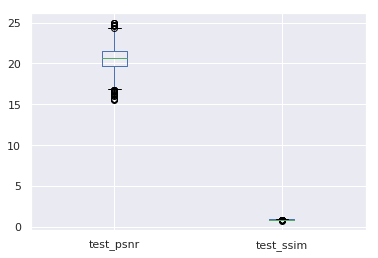

In [10]:
test_score.boxplot()

100%|██████████| 9000/9000 [01:27<00:00, 102.40it/s]

psnr mean 20.660560279755238
ssim mean 0.9240049575402395


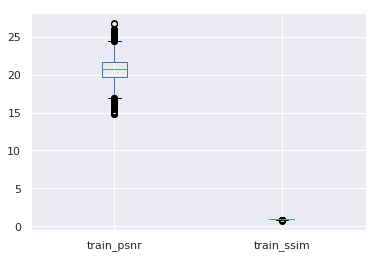

In [11]:
# train

psnrs = []
ssims = []

for x_true in tqdm(train_data[:,0]):
    x_true = x_true[np.newaxis, :]
    x_rec = F.sigmoid(decoder(encoder(x_true)[0])).array
    x_true = np.clip(x_true*255, 0, 255).astype(np.uint8).reshape(64,64)
    x_rec = np.clip(x_rec*255, 0, 255).astype(np.uint8).reshape(64,64)
    psnrs.append(compare_psnr(x_true, x_rec))
    ssims.append(compare_ssim(x_true, x_rec))

print("psnr mean", np.mean(psnrs))
print("ssim mean", np.mean(ssims))

train_score = pd.DataFrame(np.array([psnrs, ssims]).T, columns=['train_psnr', 'train_ssim'])
train_score.boxplot()

In [12]:
train_score.to_csv('images/SSVG/SSVG_train_score.csv')
test_score.to_csv('images/SSVG/SSVG_test_score.csv')

In [13]:
z1 = chainer.Variable(np.random.randn(10, 100))
z3 = chainer.Variable(np.random.randn(10, 100))

# 内積
inprd = F.sum(z1 * z3, axis=1) / ( F.sqrt(F.batch_l2_norm_squared(z1)) * F.sqrt(F.batch_l2_norm_squared(z3)) )
t = F.reshape(F.arccos(inprd), (-1, 1))
# z2 = F.sin(0.5* t) / F.sin(t) * z1 + F.sin(0.5* t) / F.sin(t) * z3


(9, 2)
(9, 2)


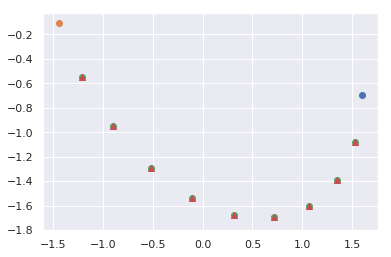

In [14]:
def spherp(z1, z2, m=0.5):
    inprd = F.sum(z1 * z2, axis=1) / (F.sqrt(F.batch_l2_norm_squared(z1)) * F.sqrt(F.batch_l2_norm_squared(z2)))
    t = F.reshape(F.arccos(inprd), (-1, 1))
    return (F.sin((1-m)* t) * z1 + F.sin(m* t) * z2) / F.sin(t)

def np_spherp(z1, z2, m=0.5):
    z1 = z1.reshape(-1)
    z2 = z2.reshape(-1)
    θ = np.arccos(np.dot(z1/np.linalg.norm(z1), z2/np.linalg.norm(z2)))
    return (np.sin((1 - m)*θ) * z1 + np.sin(m*θ) * z2) / np.sin(θ)

_z1 = np.random.randn(1, 2)
_z2 = np.random.randn(1, 2)
_z3s = F.concat([spherp(_z1, _z2, m) for m in np.arange(0.1, 1, 0.1)], axis=0).array
_z3np = np.array([np_spherp(_z1, _z2, m) for m in np.arange(0.1, 1, 0.1)])
print(_z3s.shape)
plt.scatter(*_z1.T)
plt.scatter(*_z2.T)
plt.scatter(_z3s[:,0], _z3s[:,1])
plt.scatter(_z3np[:,0], _z3np[:,1], marker='^')
print(_z3s.shape)
plt.show()
plt.close()

In [15]:
num_if = 10
seqs = []

midpoint = np.linspace(0, 1, num_if).astype(np.float32).reshape(num_if, 1, 1)

for i in tqdm(range(10)):
    xs = test_data[i, [0, 2, 4],:]
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        zs = encoder(xs)[0].array
        z0 = F.reshape(zs[0], (1, -1))
        z1 = F.reshape(zs[1], (1, -1))
        z2 = F.reshape(zs[2], (1, -1))
        
        z_si_01 = F.stack([spherp(z0, z1, m) for m in np.linspace(0, 1, 10)], axis=0).array
        z_si_12 = F.stack([spherp(z1, z2, m) for m in np.linspace(0, 1, 10)], axis=0).array
        
        x_seq01 = F.sigmoid(decoder(z_si_01.reshape(-1, 100))).array
        x_seq12 = F.sigmoid(decoder(z_si_12.reshape(-1, 100))).array

    x_seq = np.concatenate((x_seq01, x_seq12[1:]), axis=0) \
                .reshape(-1, 64, 64).transpose(1, 0, 2).reshape(64, -1)

    seqs.append(x_seq)

seqs = np.array(seqs)
seq_images = np.clip(seqs * 255, 0, 255).astype(np.uint8)

100%|██████████| 10/10 [00:00<00:00, 14.80it/s]


In [16]:
gif_images = seq_images.reshape(10, 64, -1, 64).transpose(0, 2, 1, 3)

for idx, seq in enumerate(gif_images):
    ims = []
    for fr in seq:
        ims.append(Image.fromarray(fr).convert('RGB'))
    ims[0].save('images/SSVG/mmnist_ssvg_{}.gif'.format(idx), save_all=True, append_images=ims[1:],
                optimize=False, duration=100, loop=0)

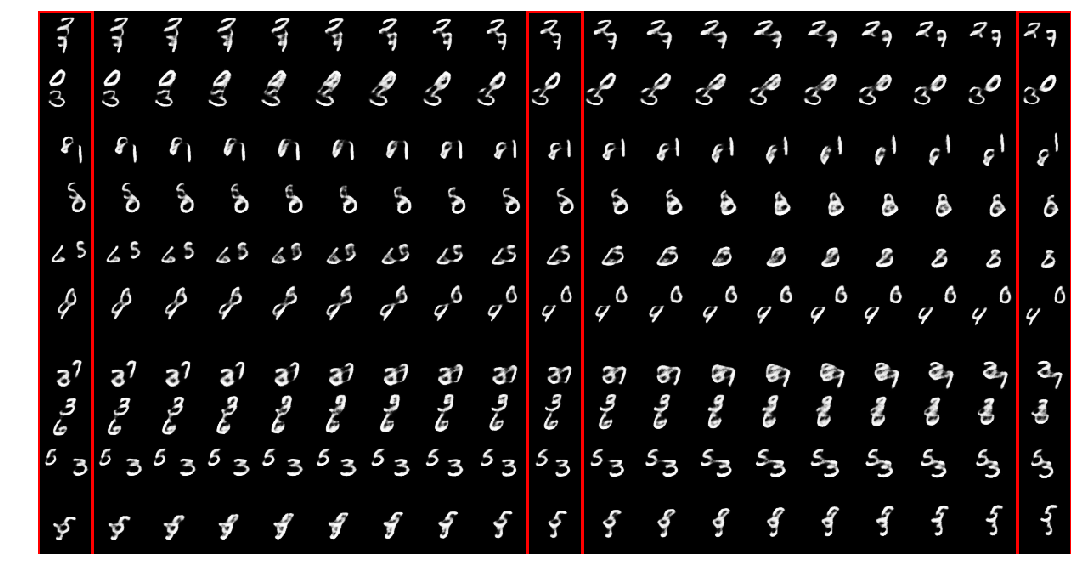

In [17]:
plt.figure(figsize=(19, 10))
plt.imshow(seq_images.reshape(640, 19*64), cmap='gray')
plt.imsave('./images/SSVG/sequence_SSVG_mmnist_noframe.png',
           seq_images.reshape(640, 19*64), cmap='gray')
# plt.imshow(seqs_u, cmap='gray')

plt.axis('off')
rect = patches.Rectangle(xy=(0,0), width=64, height=640, fill=False, ec="red", linewidth="3.0")
ax = plt.gca().add_patch(rect)
rect = patches.Rectangle(xy=(64*9,0), width=64, height=640, fill=False, ec="red", linewidth="3.0")
ax = plt.gca().add_patch(rect)
rect = patches.Rectangle(xy=(64*18,0), width=64, height=640, fill=False, ec="red", linewidth="3.0")
ax = plt.gca().add_patch(rect)
plt.savefig('./images/SSVG/sequence_SSVG_mmnist.png',
            pad_inches=0, bbox_inces='tight')
plt.show()
plt.close()